In [33]:
import psutil
import csv
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from threading import Thread, Event

In [34]:
# Глобальный флаг для остановки
stop_event = Event()

In [35]:
# Функция для записи в файл
def write_csv(timestamp, sent, received):
    with open("traffic_record.csv", mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, sent, received])

In [36]:
# Функция для построения графика
def update_plot():
    try:
        # Читаем файл при помощи пандас
        data = pd.read_csv("traffic_record.csv")

        # Конвертируем временной столбец в datetime
        data['Время'] = pd.to_datetime(data['Время'])

        # Считаем общее количество трафика
        data['Общее количество трафика'] = data['Отправлено байт'] + data["Принято байт"]

        # Очищаем текущий график
        plt.clf()

        # Строим новый график
        plt.plot(data['Время'], data['Общее количество трафика'], label='Общее количество трафика', color='blue')
        plt.xlabel('Время')
        plt.ylabel('Общее количество трафика (байт)')
        plt.title('Сетевой трафик')
        plt.legend()
        plt.grid()
        plt.xticks(rotation=45)

        # Обновляем график
        plt.draw()
        plt.pause(1)  # Пауза для обновления графика (ставится в секундах)
    except Exception as e:
        print(f"Ошибка при обновлении графика: {e}")

In [37]:
# Функция для обновления графика
def update_graph():
    while not stop_event.is_set():
        try:
            update_plot()
            stop_event.wait(30) # Ставим время для обновления графика
        except Exception as e:
            print(f"Ошибка в потоке графика: {e}")
            break

In [38]:
# Функция для сбора трафика
def collect_traffic():
    # Получаем начальные данные о трафике
    net_io = psutil.net_io_counters()
    sent_start = net_io.bytes_sent
    received_start = net_io.bytes_recv

    print("Работает программа, сохраняются данные")

    while not stop_event.is_set():
        try:
            # Время (ставится в секундах)
            stop_event.wait(10)
            if stop_event.is_set():
                break

            # Получаем данные о трафике снова
            net_io = psutil.net_io_counters()
            sent_end = net_io.bytes_sent
            received_end = net_io.bytes_recv

            # Рассчитываем разницу за промежуток времени
            sent = sent_end - sent_start
            received = received_end - received_start

            # Получаем текущую метку времени
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Записываем данные в CSV
            write_csv(timestamp, sent, received)

            # Обновляем начальные данные для следующего цикла
            sent_start = sent_end
            received_start = received_end
        
        except Exception as e:
            print(f"Ошибка в потоке сбора трафика: {e}")
            break


In [39]:
# Функция для остановки программы
def stop_program():
    print("\nОстановка программы")
    stop_event.set()
    plt.close()

Работает программа, сохраняются данные
Программа запущена. Нажмите Ctrl+C для остановки


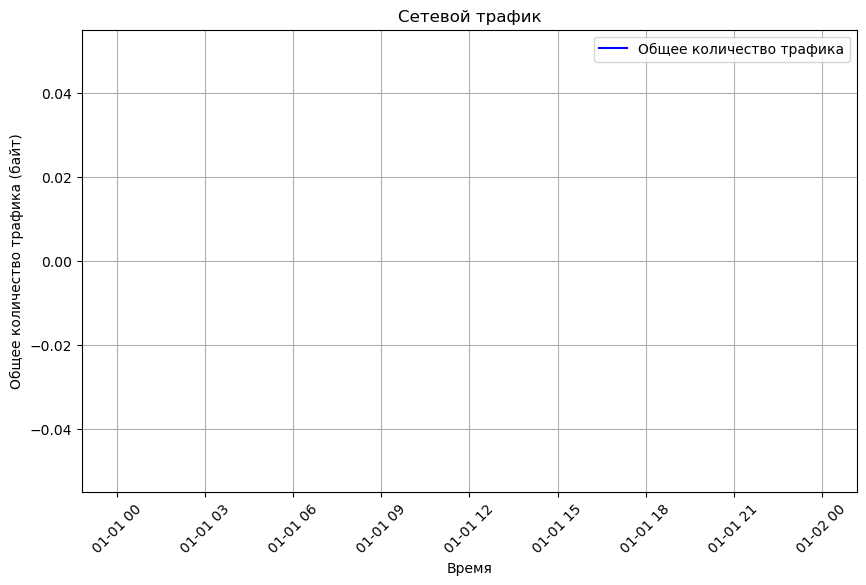

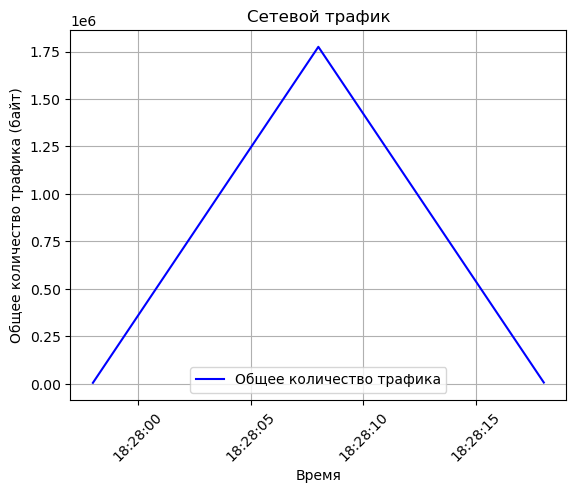


Получени сигнал остановки

Остановка программы
Программа остановлена


In [40]:
# Запускаем сбор трафика
if __name__ == "__main__":
    # Создаем файл и записываем заголовки
    with open("traffic_record.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Время', 'Отправлено байт', 'Принято байт'])

    # Включаем интерактивный режим
    plt.ion()
    plt.figure(figsize=(10, 6))

    # Запускаем сбор трафика и построение графиков в параллельных потоках
    traffic_thread = Thread(target=collect_traffic)
    graph_thread = Thread(target=update_graph)

    traffic_thread.start()
    graph_thread.start()

    print("Программа запущена. Нажмите Ctrl+C для остановки")

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("\nПолучени сигнал остановки")
        stop_program()
        traffic_thread.join()
        graph_thread.join()
        print("Программа остановлена")